# Forest Plots from BIRDMAn Output

In [7]:
#import packages 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import qiime2 as q2
from filtering_significance import filter_significance

In [8]:
#load BIRDMAn outputs for each variable
birdman_path = '/home/lakhatib/Wisconsin_MARS/metagenomics/birdman'
#list the outcomes you're interested in
outcomes = ['diagnosis', 'amyloid', 'apoe4']

# Give a title for each outcome
outcome_to_title = {
    'diagnosis': 'Diagnosis Status',
    'amyloid': 'Amyloid Status',
    'apoe4': '$\mathit{APOE}$ $\mathit{ε4}$ Status'
}

#insert the output path for your figuresoutput_path = "/home/lakhatib/BIRDMAn_output_scripts/figures"

# Load the data
df = {} 
for outcome in outcomes:
    #remove .nc files from inferences directory to clean/make space on server 
    if os.path.exists(f"{birdman_path}/{outcome}/inferences/birdman_feature-table"):
        !rm -r {birdman_path}/{outcome}/inferences/birdman_feature-table
    else:
        print(f"No {outcome} inferences directory found...")
    #load summarized inferences table
    df[outcome] = pd.read_csv(f"{birdman_path}/{outcome}/species/inferences-results/{outcome}_birdman_l7_ft.beta_var.tsv", sep="\t")

No diagnosis inferences directory found...
No amyloid inferences directory found...
No apoe4 inferences directory found...


In [10]:
for outcome in outcomes:
    if outcome == 'diagnosis':
        reverse_values = True
    else:
        reverse_values = False 
    
    df[outcome], _, _ = filter_significance(df[outcome], reverse_values=reverse_values, top_40=True)

Test column: diagnosis[T.Normal]
Total features before filtering: 651
Significant features: 252
Top Features: 20
Bottom Features: 20
Test column: amyloid[T.Positive]
Total features before filtering: 651
Significant features: 174
Top Features: 20
Bottom Features: 20
Test column: apoe4[T.Positive]
Total features before filtering: 651
Significant features: 254
Top Features: 20
Bottom Features: 20


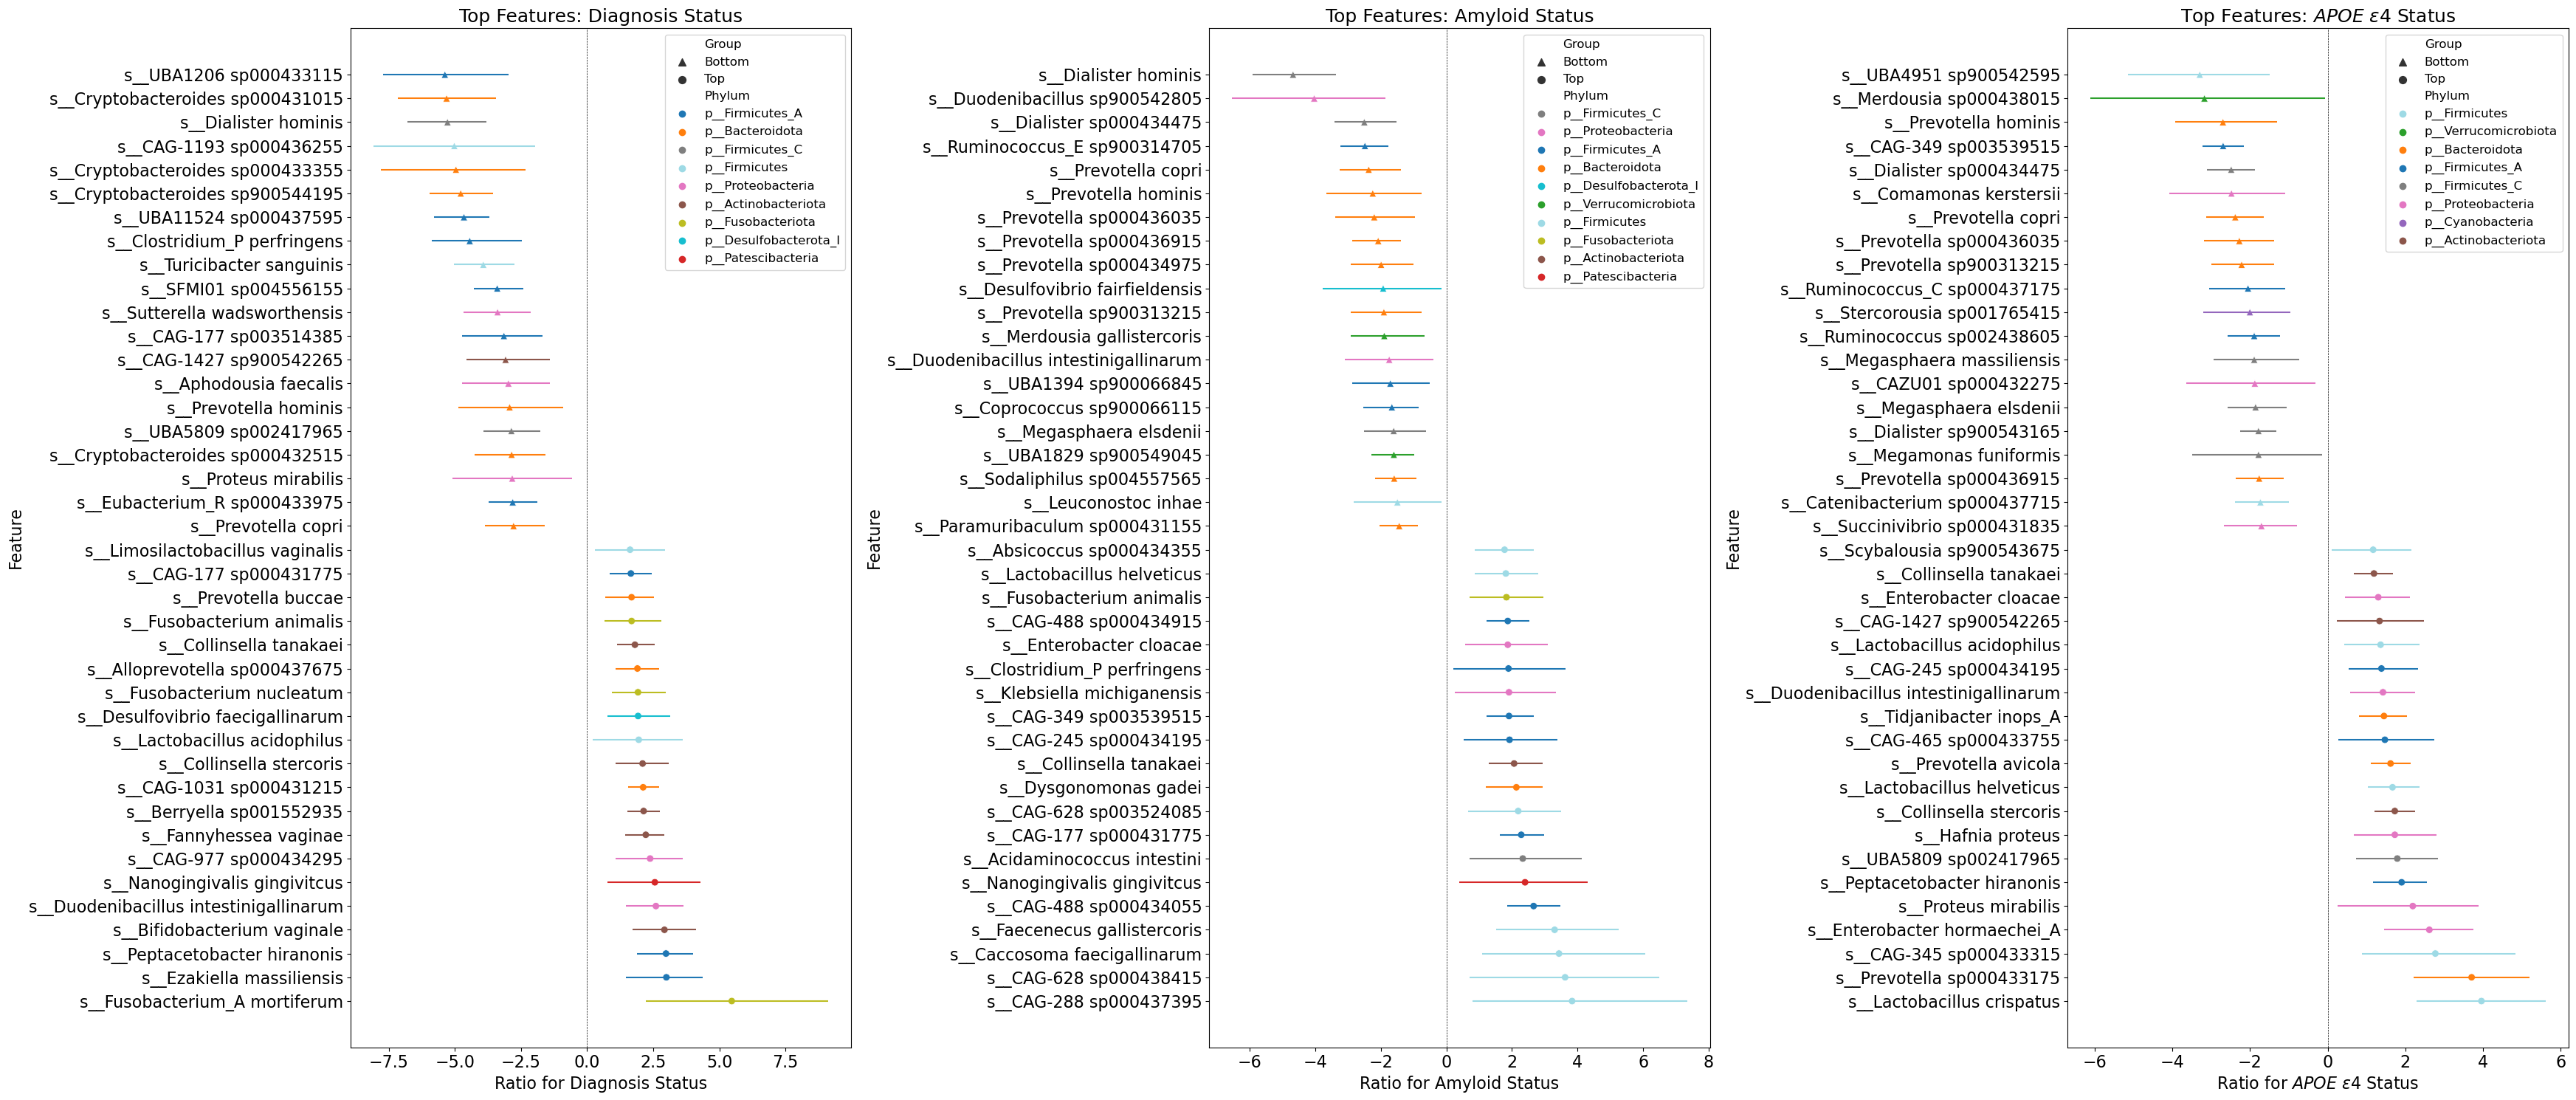

In [11]:
# Combine unique phyla from all datasets
all_phyla = set()
for dataset in df.values():
    all_phyla.update(dataset['Phylum'].unique())
all_phyla = list(all_phyla)  # Convert to list to maintain order

# Generate a color palette that has a distinct color for each unique phylum
colors = plt.cm.tab20(np.linspace(0, 1, len(all_phyla)))
color_mapping = dict(zip(all_phyla, colors))

# Your existing plot_data function, modified to automatically generate colors
def plot_data(df, ax, color_mapping):
    
    dot_plot = sns.scatterplot(
        data=df,
        x='mean',
        y='Feature',
        hue='Phylum',
        style='Group',
        palette=color_mapping,  # Use the generated color mapping
        size='Group',
        sizes={"Top": 50, "Bottom": 50},
        markers={"Top": "o", "Bottom": "^"},
        ax=ax
    )

    # Draw horizontal lines for HDI
    for index, row in df.iterrows():
        color = color_mapping.get(row['Phylum'], 'gray')
        ax.hlines(
            y=row['Feature'],
            xmin=row['lower_hdi'],
            xmax=row['upper_hdi'],
            color=color,
            linewidth=1.5
        )
    
    title = outcome_to_title[outcome]
    dot_plot.set_title(f"Top Features: {title}", fontsize=18)
    dot_plot.set_xlabel(f"Ratio for {title}", fontsize=16)
    dot_plot.set_ylabel(f"Feature", fontsize=16)
    dot_plot.axvline(x=0, linestyle="--", color="black", linewidth=0.5)
    dot_plot.tick_params(axis='y', labelsize=16)
    dot_plot.tick_params(axis='x', labelsize=16)

    # Get handles and labels for the current axes
    handles, labels = ax.get_legend_handles_labels()

    # Define new lists for the combined legend
    new_handles = []
    new_labels = []
    
    # First, add a dummy handle for the "Group" title
    from matplotlib.lines import Line2D
    group_title_handle = Line2D([], [], color='none', marker='None', linestyle='none', label='Group')
    new_handles.append(group_title_handle)
    new_labels.append('Group')

    # Next, add the actual handles for the "Group"
    for handle, label in zip(handles, labels):
        if label in ['Top', 'Bottom']:
            new_handles.append(handle)
            new_labels.append(label)

    # Now, add the handles for the "Phylum"
    for handle, label in zip(handles, labels):
        if label not in ['Top', 'Bottom', 'Group']:
            new_handles.append(handle)
            new_labels.append(label)

    # Create a single legend with the correct order
    legend = ax.legend(handles=new_handles, labels=new_labels, loc='upper right', fontsize=12, title_fontsize=14)
    ax.add_artist(legend)

    # Remove the default legend created by seaborn
    ax.legend_.remove()


# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(35, 15))

# Plot the data for each subplot using the common color_mapping
for n, outcome in enumerate(outcomes):
    plot_data(df[outcome], axes[n], color_mapping)

# Adjust layout to make room for legends
plt.tight_layout()

# Save the combined figure
plt.savefig(f'{output_path}/forest_plots.png', dpi=300, bbox_inches='tight', pad_inches=0.1)